In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
import os
from os import path
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.parse import urljoin

from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import verify_str_arg, check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset

#modify the original Places365 loader to load only data starting with a
class Places365c(VisionDataset):
    r"""`Places365 <http://places2.csail.mit.edu/index.html>`_ classification dataset.

    Args:
        root (string): Root directory of the Places365 dataset.
        split (string, optional): The dataset split. Can be one of ``train-standard`` (default), ``train-challenge``,
            ``val``.
        small (bool, optional): If ``True``, uses the small images, i. e. resized to 256 x 256 pixels, instead of the
            high resolution ones.
        download (bool, optional): If ``True``, downloads the dataset components and places them in ``root``. Already
            downloaded archives are not downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.

     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
        targets (list): The class_index value for each image in the dataset

    Raises:
        RuntimeError: If ``download is False`` and the meta files, i. e. the devkit, are not present or corrupted.
        RuntimeError: If ``download is True`` and the image archive is already extracted.
    """
    _SPLITS = ("train-standard", "train-challenge", "val")
    _BASE_URL = "http://data.csail.mit.edu/places/places365/"
    # {variant: (archive, md5)}
    _DEVKIT_META = {
        "standard": ("filelist_places365-standard.tar", "35a0585fee1fa656440f3ab298f8479c"),
        "challenge": ("filelist_places365-challenge.tar", "70a8307e459c3de41690a7c76c931734"),
    }
    # (file, md5)
    _CATEGORIES_META = ("categories_places365.txt", "06c963b85866bd0649f97cb43dd16673")
    # {split: (file, md5)}
    _FILE_LIST_META = {
        "train-standard": ("places365_train_standard.txt", "a026646418c935c845bb4f294e6b8497"),
        "train-challenge": ("places365_train_challenge.txt", "b2931dc997b8c33c27e7329c073a6b57"),
        "val": ("places365_val.txt", "e9f2fd57bfd9d07630173f4e8708e4b1"),
    }
    # {(split, small): (file, md5)}
    _IMAGES_META = {
        ("train-standard", False): ("train_large_places365standard.tar", "67e186b496a84c929568076ed01a8aa1"),
        ("train-challenge", False): ("train_large_places365challenge.tar", "605f18e68e510c82b958664ea134545f"),
        ("val", False): ("val_large.tar", "9b71c4993ad89d2d8bcbdc4aef38042f"),
        ("train-standard", True): ("train_256_places365standard.tar", "53ca1c756c3d1e7809517cc47c5561c5"),
        ("train-challenge", True): ("train_256_places365challenge.tar", "741915038a5e3471ec7332404dfb64ef"),
        ("val", True): ("val_256.tar", "e27b17d8d44f4af9a78502beb927f808"),
    }

    def __init__(
        self,
        root: str,
        split: str = "train-standard",
        small: bool = False,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self.split = self._verify_split(split)
        self.small = small
        self.loader = loader

        self.classes, self.class_to_idx = self.load_categories(download)
        self.imgs, self.targets = self.load_file_list(download)

        if download:
            self.download_images()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        file, target = self.imgs[index]
        image = self.loader(file)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self) -> int:
        return len(self.imgs)

    @property
    def variant(self) -> str:
        return "challenge" if "challenge" in self.split else "standard"

    @property
    def images_dir(self) -> str:
        size = "256" if self.small else "large"
        if self.split.startswith("train"):
            dir = f"data_{size}_{self.variant}"
        else:
            dir = f"{self.split}_{size}"
        return path.join(self.root, dir)

    def load_categories(self, download: bool = True) -> Tuple[List[str], Dict[str, int]]:
        def process(line: str) -> Tuple[str, int]:
            cls, idx = line.split()
            return cls, int(idx)

        file, md5 = self._CATEGORIES_META
        file = path.join(self.root, file)

        with open(file) as fh:
            class_to_idx = dict(process(line) for line in fh)

        return sorted(class_to_idx.keys()), class_to_idx

    def load_file_list(self, download: bool = True) -> Tuple[List[Tuple[str, int]], List[int]]:
        def process(line: str, sep="/") -> Tuple[str, int]:
            image, idx = line.split()
            return path.join(self.images_dir, image.lstrip(sep).replace(sep, os.sep)), int(idx)

        file, md5 = self._FILE_LIST_META[self.split]
        file = path.join(self.root, file)
        if not self._check_integrity(file, md5, download):
            self.download_devkit()

        with open(file) as fh:
            images = [process(line) for line in fh]

        _, targets = zip(*images)
        return images, list(targets)

    def download_devkit(self) -> None:
        file, md5 = self._DEVKIT_META[self.variant]
        download_and_extract_archive(urljoin(self._BASE_URL, file), self.root, md5=md5)

    def download_images(self) -> None:
        if path.exists(self.images_dir):
            raise RuntimeError(
                f"The directory {self.images_dir} already exists. If you want to re-download or re-extract the images, "
                f"delete the directory."
            )

        file, md5 = self._IMAGES_META[(self.split, self.small)]
        download_and_extract_archive(urljoin(self._BASE_URL, file), self.root, md5=md5)

        if self.split.startswith("train"):
            os.rename(self.images_dir.rsplit("_", 1)[0], self.images_dir)

    def extra_repr(self) -> str:
        return "\n".join(("Split: {split}", "Small: {small}")).format(**self.__dict__)

    def _verify_split(self, split: str) -> str:
        return verify_str_arg(split, "split", self._SPLITS)

    def _check_integrity(self, file: str, md5: str, download: bool) -> bool:
        integrity = check_integrity(file, md5=md5)
        if not integrity and not download:
            raise RuntimeError(
                f"The file {file} does not exist or is corrupted. You can set download=True to download it."
            )
        return integrity

In [4]:
%cd /content/drive/My\ Drive/
!pwd

/content/drive/My Drive
/content/drive/My Drive


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [13]:
from torchvision.transforms.functional import to_tensor
train_dataset=Places365c(root="Places365", small=True, download=False, transform=data_transforms["train"])
other_dataset=Places365c(root="Places365", small=True, download=False, transform=data_transforms["val"])
print(len(train_dataset))


149168


In [14]:
def train_val_test_dataset(train_dataset,other_dataset):
    train_idx, test_idx= train_test_split(list(range(len(other_dataset))), test_size=0.2,shuffle=True)
    datasets = {}
    datasets['test'] = Subset(other_dataset, test_idx)
    tmp_val = Subset(other_dataset, train_idx)
    tmp_train = Subset(train_dataset, train_idx)
    train_idx, val_idx = train_test_split(list(range(len(tmp_val))), test_size=0.1)
    datasets['train'] = Subset(tmp_train, train_idx)
    datasets['val'] = Subset(tmp_val, val_idx)
    return datasets

In [15]:
def train_test_dataset(train_dataset,other_dataset):
    train_idx, test_idx= train_test_split(list(range(len(other_dataset))), test_size=0.2,shuffle=True)
    datasets = {}
    datasets['test'] = Subset(other_dataset, test_idx)
    datasets['train'] = Subset(train_dataset, test_idx)
    return datasets

In [16]:
subset1 = torch.utils.data.Subset(train_dataset, list(range(20000)))
subset2 = torch.utils.data.Subset(other_dataset, list(range(20000)))
image_datasets = train_val_test_dataset(subset1, subset2)
dataloaders = {x:DataLoader(image_datasets[x],batch_size=4, shuffle=True, num_workers=13) for x in ['train','val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)
class_names = [x[3:] for x in train_dataset.load_categories(False)[0]]
for i in range (1):
  inputs, classes = next(iter(dataloaders['train']))
  for x in classes:
    print(class_names[x])
    print(" ")

{'train': 14400, 'val': 1600, 'test': 4000}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


airfield
 
airfield
 
airfield
 
alcove
 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


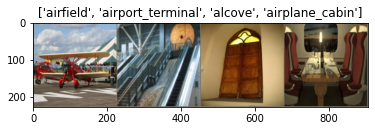

In [17]:
#@title
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
from torch.nn.modules.activation import Softmax
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.pooling import MaxPool2d
import torch.nn.functional as F


class VGG11(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(128, 256, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(256, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2)
        )

        self.linear = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 30),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.linear(x)
        return x



In [7]:
from torch.nn.modules.activation import Softmax
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.pooling import MaxPool2d
import torch.nn.functional as F


class new_VGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(128, 256, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(256, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(512, 512, 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2)
        )

        self.linear = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 30),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.linear(x)
        return x

net = new_VGG16()

In [35]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cpu


new_VGG16(
  (convolution): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=

In [21]:
def train_model(model, criterion, optimizer, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc=[]
    test_acc=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_acc.append(epoch_acc)
            else:
                test_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc,test_acc

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

model, train_acc, test_acc = train_model(net, criterion, optimizer, 10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.4601 Acc: 0.2502
val Loss: 1.4053 Acc: 0.2412

Epoch 1/9
----------
train Loss: 1.4009 Acc: 0.2528
val Loss: 1.4125 Acc: 0.2412

Epoch 2/9
----------
train Loss: 1.4031 Acc: 0.2464
val Loss: 1.3964 Acc: 0.2456

Epoch 3/9
----------
train Loss: 1.3993 Acc: 0.2488
val Loss: 1.3937 Acc: 0.2506

Epoch 4/9
----------
train Loss: 1.3977 Acc: 0.2537
val Loss: 1.4001 Acc: 0.2506

Epoch 5/9
----------
train Loss: 1.3958 Acc: 0.2550
val Loss: 1.3924 Acc: 0.2456

Epoch 6/9
----------


In [2]:
train_acc = [0.2444, 0.2459, 0.2493, 0.2433, 0.2538, 0.2512, 0.2580, 0.2522, 0.2470, 0.2474, 0.2497, 0.2475, 0.2460, 0.2431, 0.2483, 0.2489, 0.2504, 0.2465, 0.2445]
test_acc = [0.2419, 0.2513, 0.2444, 0.2525, 0.2375, 0.2569, 0.2481, 0.2587, 0.2600, 0.2562, 0.2431, 0.2406, 0.2412, 0.2550, 0.2388, 0.2650, 0.2600, 0.2475, 0.2583]

In [1]:
train_acc = [0.2502, 0.2528, 0.2464, 0.2488, 0.2537, 0.2550]
test_acc = [0.2412, 0.2412, 0.2456, 0.2506, 0.2506, 0.2456]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


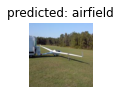

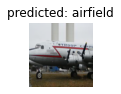

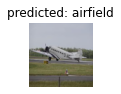

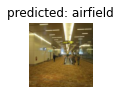

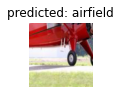

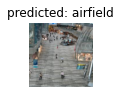

In [ ]:
visualize_model(model)

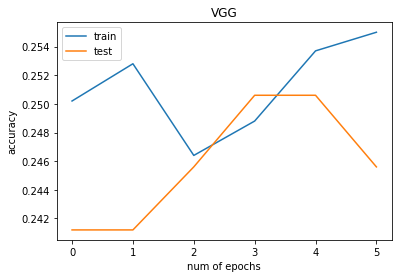

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(range(6),[x for x in train_acc],label="train")
plt.plot(range(6),[x for x in test_acc],label="test")
plt.xlabel("num of epochs")
plt.ylabel("accuracy")
plt.title("VGG")
plt.legend()
plt.show()

In [ ]:

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 13 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [7]:
#Training Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1250 test images: %d %%' % (
    100 * correct / total))

NameError: ignored